# Beubli V11 - Introduction

We previously extracted features from the french bible sentence dataset.  
We are now interested in the infered gender of each subject.  

Eg. Jonas is a man, Rachel is a woman. 

# Imports and config

## Lib and dataset import

In [1]:
#load libs
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import re
import pprint   # For proper print of sequences.
# import treetaggerwrapper
from nltk.tokenize import sent_tokenize 
import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
sentence_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ressources/la beubli/sentence_dataset/translation_plus_ner_plus_pro_per__plus_en_extraction.csv', index_col=0)

## CamenBert install and model import

In [3]:
%%bash
pip install fairseq
pip install sentencepiece
wget https://dl.fbaipublicfiles.com/fairseq/models/camembert-base.tar.gz
tar -xzvf camembert-base.tar.gz

  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=78500757d82dd0e62a4d4b6155fab6416597ae94050534a352c4b4f84157d775
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
camembert-base/
camembert-base/LICENSE
camembert-base/dict.txt
camembert-base/model.pt
camembert-base/sentencepiece.bpe.model


--2022-03-24 00:21:00--  https://dl.fbaipublicfiles.com/fairseq/models/camembert-base.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1012630426 (966M) [application/gzip]
Saving to: ‘camembert-base.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  155K 1h46m
    50K .......... .......... .......... .......... ..........  0% 3.72M 55m25s
   100K .......... .......... .......... .......... ..........  0%  326K 53m47s
   150K .......... .......... .......... .......... ..........  0% 52.7M 40m24s
   200K .......... .......... .......... .......... ..........  0% 69.0M 32m22s
   250K .......... .......... .......... .......... ..........  0%  328K 35m20s
   300K .......... .......... .......... .......... ..........  0% 76.0M 30m19s
   350K .......... ..

In [4]:
from fairseq.models.roberta import CamembertModel
camembert = CamembertModel.from_pretrained('/content/camembert-base/')
camembert.eval()  # disable dropout (or leave in train mode to finetune)

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerSentenceEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(32005, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layers): ModuleList(
          (0): TransformerSentenceEncoderLayer(
            (dropout_module): FairseqDropout()
            (activation_dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=T

In [5]:
masked_line = 'Le camembert est <mask> :)'
camembert.fill_mask(masked_line, topk=3)

[('Le camembert est délicieux :)', 0.49091124534606934, ' délicieux'),
 ('Le camembert est excellent :)', 0.10556939989328384, ' excellent'),
 ('Le camembert est succulent :)', 0.03453318402171135, ' succulent')]

# Sex analysis of PER and MISC

We analyse the `ner_text` and `ner_label` features to clean data.

## Create a short list of all PER words

In [6]:
proper_df = sentence_dataset.copy()
proper_df.dropna(inplace=True)
proper_df['ner_label'] = proper_df['ner_label'].astype(str)

In [7]:
proper_df

,chapter_number,page_number,line_number,sentence_number,sentence,en_translation,ner_text,ner_label,loc_count,per_count,misc_count,il_count,other_pron_count,he_count,there_count,she_it_them_count
39,1.0,1.0,27,0,"Dieu créa l'homme à son image, il le créa à l'...","God created man in his image, he created him i...",Dieu (14),PER (0.3378),0,1,0,2,0,2,0,0
51,1.0,2.0,5,0,aucun arbuste des champs n'était encore sur la...,"No shrub of the field was yet on the earth, an...","l'Eternel Dieu (21,22)",PER (0.7178),0,1,0,1,0,0,1,0
54,1.0,2.0,8,0,"Puis l'Eternel Dieu planta un jardin en Eden, ...",And the LORD God planted a garden in Eden on t...,"l'Eternel Dieu (2,3),Eden (8)","PER (0.6561),LOC (0.9617)",1,1,0,1,0,1,1,0
57,1.0,2.0,11,0,Le nom du premier est Pischon; c'est celui qui...,The name of the first is Pischon; it is he tha...,"Pischon (6),Havila (16)","PER (0.8971),LOC (0.5471)",1,1,0,0,0,1,0,1
59,1.0,2.0,13,0,Le nom du second fleuve est Guihon; c'est celu...,The name of the second river is Gihon; it is t...,"Guihon (7),Cusch (17)","PER (0.604),PER (0.4421)",0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40850,66.0,22.0,16,1,"Je suis le rejeton et la postérité de David, l...","I am the offspring of David, the bright mornin...",David (9),PER (0.9266),0,1,0,0,0,0,0,0
40851,66.0,22.0,17,0,Et l'Esprit et l'épouse disent: Viens.,"And the Spirit and the bride say, Come.",Viens (7),LOC (0.5861),1,0,0,0,0,0,0,0
40852,66.0,22.0,17,1,Et que celui qui entend dise: Viens.,"And let him that hears say, Come.",Viens (8),LOC (0.7749),1,0,0,0,0,0,0,0
40858,66.0,22.0,20,2,"Viens, Seigneur Jésus!","Come, Lord Jesus!","Seigneur Jésus (3,4)",MISC (0.865),0,0,1,0,0,0,0,0


In [8]:
unique_per_df = pd.DataFrame(proper_df[proper_df.ner_label.str.contains('PER')].ner_text.unique(), columns=['name'])
#  remove "(1, 2)" type expressions from names
unique_per_df['name'] = unique_per_df['name'].str.replace(r'\ \(.*?\)', '')

# 
unique_per_df.drop_duplicates(inplace=True)
unique_per_df = unique_per_df.name.str.split(',', expand=True)

# melt and remove col ids
unique_per_df = unique_per_df.melt()
unique_per_df.columns = ['to_drop', 'name']
del unique_per_df['to_drop']
unique_per_df.drop_duplicates(inplace=True)

# keep strings more than 1 char long
unique_per_df = unique_per_df[unique_per_df.name.str.len() > 1]
unique_per_df

,name
0,Dieu
1,l'Eternel Dieu
3,Pischon
4,Guihon
5,Hiddékel
...,...
62713,Joschbekascha
68133,Mallothi
73553,Hothir
73802,d'Azaria


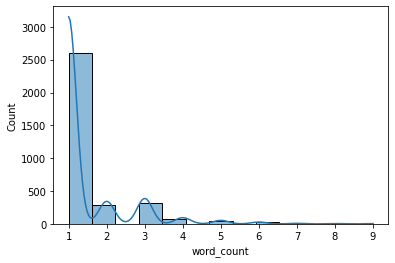

In [9]:
# add word count
unique_per_df['word_count'] = unique_per_df.name.str.split(' ').str.len()
sns.histplot(data=unique_per_df, x='word_count', kde=True)

In [10]:
unique_per_df

,name,word_count
0,Dieu,1
1,l'Eternel Dieu,2
3,Pischon,1
4,Guihon,1
5,Hiddékel,1
...,...,...
62713,Joschbekascha,1
68133,Mallothi,1
73553,Hothir,1
73802,d'Azaria,1


We have a list of proper nouns. It still contains sentence pieces.

## Run another PER on the short list


We previously ran a multilingual fast NER parser, we will switch to the "french slow" version.

In [11]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 895 kB 47.5 MB/s 
     |████████████████████████████████| 6.5 MB 35.8 MB/s 


In [12]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")


##### Process text sample (from wikipedia)

from transformers import pipeline

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")
nlp("Apple est créée le 1er avril 1976 dans le garage de la maison d'enfance de Steve Jobs à Los Altos en Californie par Steve Jobs, Steve Wozniak et Ronald Wayne14, puis constituée sous forme de société le 3 janvier 1977 à l'origine sous le nom d'Apple Computer, mais pour ses 30 ans et pour refléter la diversification de ses produits, le mot « computer » est retiré le 9 janvier 2015.")



Downloading:   0%|          | 0.00/269 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

[{'end': 5,
  'entity_group': 'ORG',
  'score': 0.9921588,
  'start': 0,
  'word': 'Apple'},
 {'end': 85,
  'entity_group': 'PER',
  'score': 0.99597645,
  'start': 74,
  'word': 'Steve Jobs'},
 {'end': 97,
  'entity_group': 'LOC',
  'score': 0.99835855,
  'start': 87,
  'word': 'Los Altos'},
 {'end': 111,
  'entity_group': 'LOC',
  'score': 0.9982911,
  'start': 100,
  'word': 'Californie'},
 {'end': 126,
  'entity_group': 'PER',
  'score': 0.99870753,
  'start': 115,
  'word': 'Steve Jobs'},
 {'end': 141,
  'entity_group': 'PER',
  'score': 0.99879086,
  'start': 127,
  'word': 'Steve Wozniak'},
 {'end': 157,
  'entity_group': 'PER',
  'score': 0.99646753,
  'start': 144,
  'word': 'Ronald Wayne'},
 {'end': 257,
  'entity_group': 'ORG',
  'score': 0.9449747,
  'start': 243,
  'word': 'Apple Computer'}]

In [13]:
# test_sentence = unique_per_df.loc[unique_per_df.index == 3412, :]

test_sentence = "maison de Dieu à Jérusalem"



In [14]:
final_name_list = []
for name in tqdm(unique_per_df.name):
  for ner_tag in nlp(name):
    final_name_list.append(ner_tag)

new_ner_extraction = pd.DataFrame(final_name_list)

  0%|          | 0/3358 [00:00<?, ?it/s]

In [15]:
new_ner_extraction

,entity_group,score,word,start,end
0,MISC,0.764100,Dieu,0,4
1,PER,0.806295,'Eternel Dieu,1,14
2,PER,0.550172,Pischon,0,7
3,LOC,0.501794,Gui,0,3
4,PER,0.495978,hon,3,6
...,...,...,...,...,...
3568,PER,0.998901,Joschbekascha,0,13
3569,PER,0.834658,Mallothi,0,8
3570,PER,0.947194,Hothir,0,6
3571,PER,0.945887,Azaria,2,8


In [16]:
new_ner_extraction.entity_group.value_counts()

PER     2253
MISC     643
LOC      630
ORG       47
Name: entity_group, dtype: int64

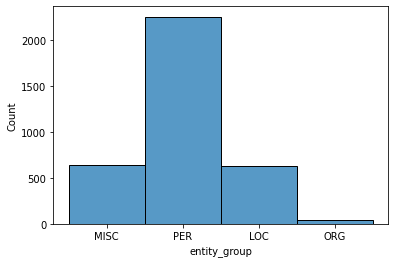

In [17]:
sns.histplot(data=new_ner_extraction, x='entity_group')

In [18]:
new_proper_noun_list = new_ner_extraction[new_ner_extraction.entity_group == 'PER'].word
new_proper_noun_list = new_proper_noun_list.drop_duplicates().to_frame()
new_proper_noun_list

final_name_list = []
for name in tqdm(new_proper_noun_list.word):
  for ner_tag in nlp(name):
    final_name_list.append(ner_tag)

new_new_ner_extraction = pd.DataFrame(final_name_list)

  0%|          | 0/1852 [00:00<?, ?it/s]

In [19]:
new_new_ner_extraction

,entity_group,score,word,start,end
0,PER,0.764344,Eternel Dieu,1,13
1,PER,0.550172,Pischon,0,7
2,PER,0.914148,hon,0,3
3,PER,0.739055,Adam,0,4
4,PER,0.946943,Abel,0,4
...,...,...,...,...,...
1847,PER,0.939060,Nehum,0,5
1848,PER,0.995515,Maacathien,0,10
1849,PER,0.998901,Joschbekascha,0,13
1850,PER,0.834658,Mallothi,0,8


By running the process a second time, we obtain pure bullshit. Impossible to differentiate random words from real entities. 

Should we stop at the first cleaning step, or change the whole process ?

# New try : extract NER from complete bible again

This NER seems more efficient, but also quite slow. 
We will select device 0 to activate GPU boost. 

For this same reason, we will have to change notebooks as all the previous code is has been CPU generated, and the whole notebook needs to be restarted.

In [20]:
sentence_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ressources/la beubli/sentence_dataset/translation_plus_ner_plus_pro_per__plus_en_extraction.csv', index_col=0)

In [21]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")


##### Process text sample (from wikipedia)

from transformers import pipeline

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")
nlp("Apple est créée le 1er avril 1976 dans le garage de la maison d'enfance de Steve Jobs à Los Altos en Californie par Steve Jobs, Steve Wozniak et Ronald Wayne14, puis constituée sous forme de société le 3 janvier 1977 à l'origine sous le nom d'Apple Computer, mais pour ses 30 ans et pour refléter la diversification de ses produits, le mot « computer » est retiré le 9 janvier 2015.")



[{'end': 5,
  'entity_group': 'ORG',
  'score': 0.9921588,
  'start': 0,
  'word': 'Apple'},
 {'end': 85,
  'entity_group': 'PER',
  'score': 0.99597645,
  'start': 74,
  'word': 'Steve Jobs'},
 {'end': 97,
  'entity_group': 'LOC',
  'score': 0.99835855,
  'start': 87,
  'word': 'Los Altos'},
 {'end': 111,
  'entity_group': 'LOC',
  'score': 0.9982911,
  'start': 100,
  'word': 'Californie'},
 {'end': 126,
  'entity_group': 'PER',
  'score': 0.99870753,
  'start': 115,
  'word': 'Steve Jobs'},
 {'end': 141,
  'entity_group': 'PER',
  'score': 0.99879086,
  'start': 127,
  'word': 'Steve Wozniak'},
 {'end': 157,
  'entity_group': 'PER',
  'score': 0.99646753,
  'start': 144,
  'word': 'Ronald Wayne'},
 {'end': 257,
  'entity_group': 'ORG',
  'score': 0.9449747,
  'start': 243,
  'word': 'Apple Computer'}]

In [22]:
final_name_list = []
for name in tqdm(unique_per_df.name):
  for ner_tag in nlp(name):
    final_name_list.append(ner_tag)

new_ner_extraction = pd.DataFrame(final_name_list)

  0%|          | 0/3358 [00:00<?, ?it/s]

In [23]:
new_ner_extraction

,entity_group,score,word,start,end
0,MISC,0.764100,Dieu,0,4
1,PER,0.806295,'Eternel Dieu,1,14
2,PER,0.550172,Pischon,0,7
3,LOC,0.501794,Gui,0,3
4,PER,0.495978,hon,3,6
...,...,...,...,...,...
3568,PER,0.998901,Joschbekascha,0,13
3569,PER,0.834658,Mallothi,0,8
3570,PER,0.947194,Hothir,0,6
3571,PER,0.945887,Azaria,2,8
